# Matrix factorization

In this notebook, we'll finally start implementing recommender system algorithms. First, we'll look at a simple dataset, then implement the matrix factorization model and train it.

In [ ]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras import models

tf.random.set_seed(343)

In [ ]:
# Clean up the logdir if it exists
import shutil
shutil.rmtree('logs', ignore_errors=True)

# Load TensorBoard extension for notebooks
%load_ext tensorboard

To start, let's download the data and see how it looks like. 

In [ ]:
movielens_ratings_file = 'https://github.com/janhartman/recsystf/raw/master/datasets/movielens_ratings.csv'
df = pd.read_csv(movielens_ratings_file)
df

Let's preprocess the data. We'll encode each unique user and movie with an index from 0 to $n-1$. We could reuse already existing IDs, but it's better to have our own mapping (+ this approach is more general and would also work for e.g. names).

In [ ]:
user_ids = df['userId'].unique()
user_encoding = {x: i for i, x in enumerate(user_ids)}   # {user_id: index}
movie_ids = df['movieId'].unique()
movie_encoding = {x: i for i, x in enumerate(movie_ids)} # {movie_id: index}

df['user'] = df['userId'].map(user_encoding)    # Map from IDs to indices
df['movie'] = df['movieId'].map(movie_encoding)

n_users = len(user_ids)
n_movies = len(movie_ids)

min_rating = min(df['rating'])
max_rating = max(df['rating'])

print(f'Number of users: {n_users}\nNumber of movies: {n_movies}\nMin rating: {min_rating}\nMax rating: {max_rating}')

# Shuffle the data
df = df.sample(frac=1, random_state=42)

Now, we'll build the model. We'll do this in a new way: by subclassing the `Model` class and implementing the necessary functionality. Note: this way of building is typically not recommended if you're not looking to significantly change a model's behavior - we're showing it for completeness' sake. 

The implementation is divided into the creation and application of the layers and is otherwise quite similar to what we've already seen. The most important layer we'll be using is the `Embedding` layer. It is essentially a look-up array of weights, where each row is an entity (user or movie) represented with $n$ latent dimensions. Its inputs have to be integer indices on the range $[0, n-1]$, which is why we encoded the IDs. Then, a call of this layer with an index $i$ returns the $i$-th row of this matrix. This is a great way of handling sparse inputs which are omnipresent in recommender systems. At Zemanta, we also utilize this layer in our models. Essentially, we are decomposing the sparse user-movie rating matrix into two dense matrices held in two of these embedding layers.

#### Scheme of the model

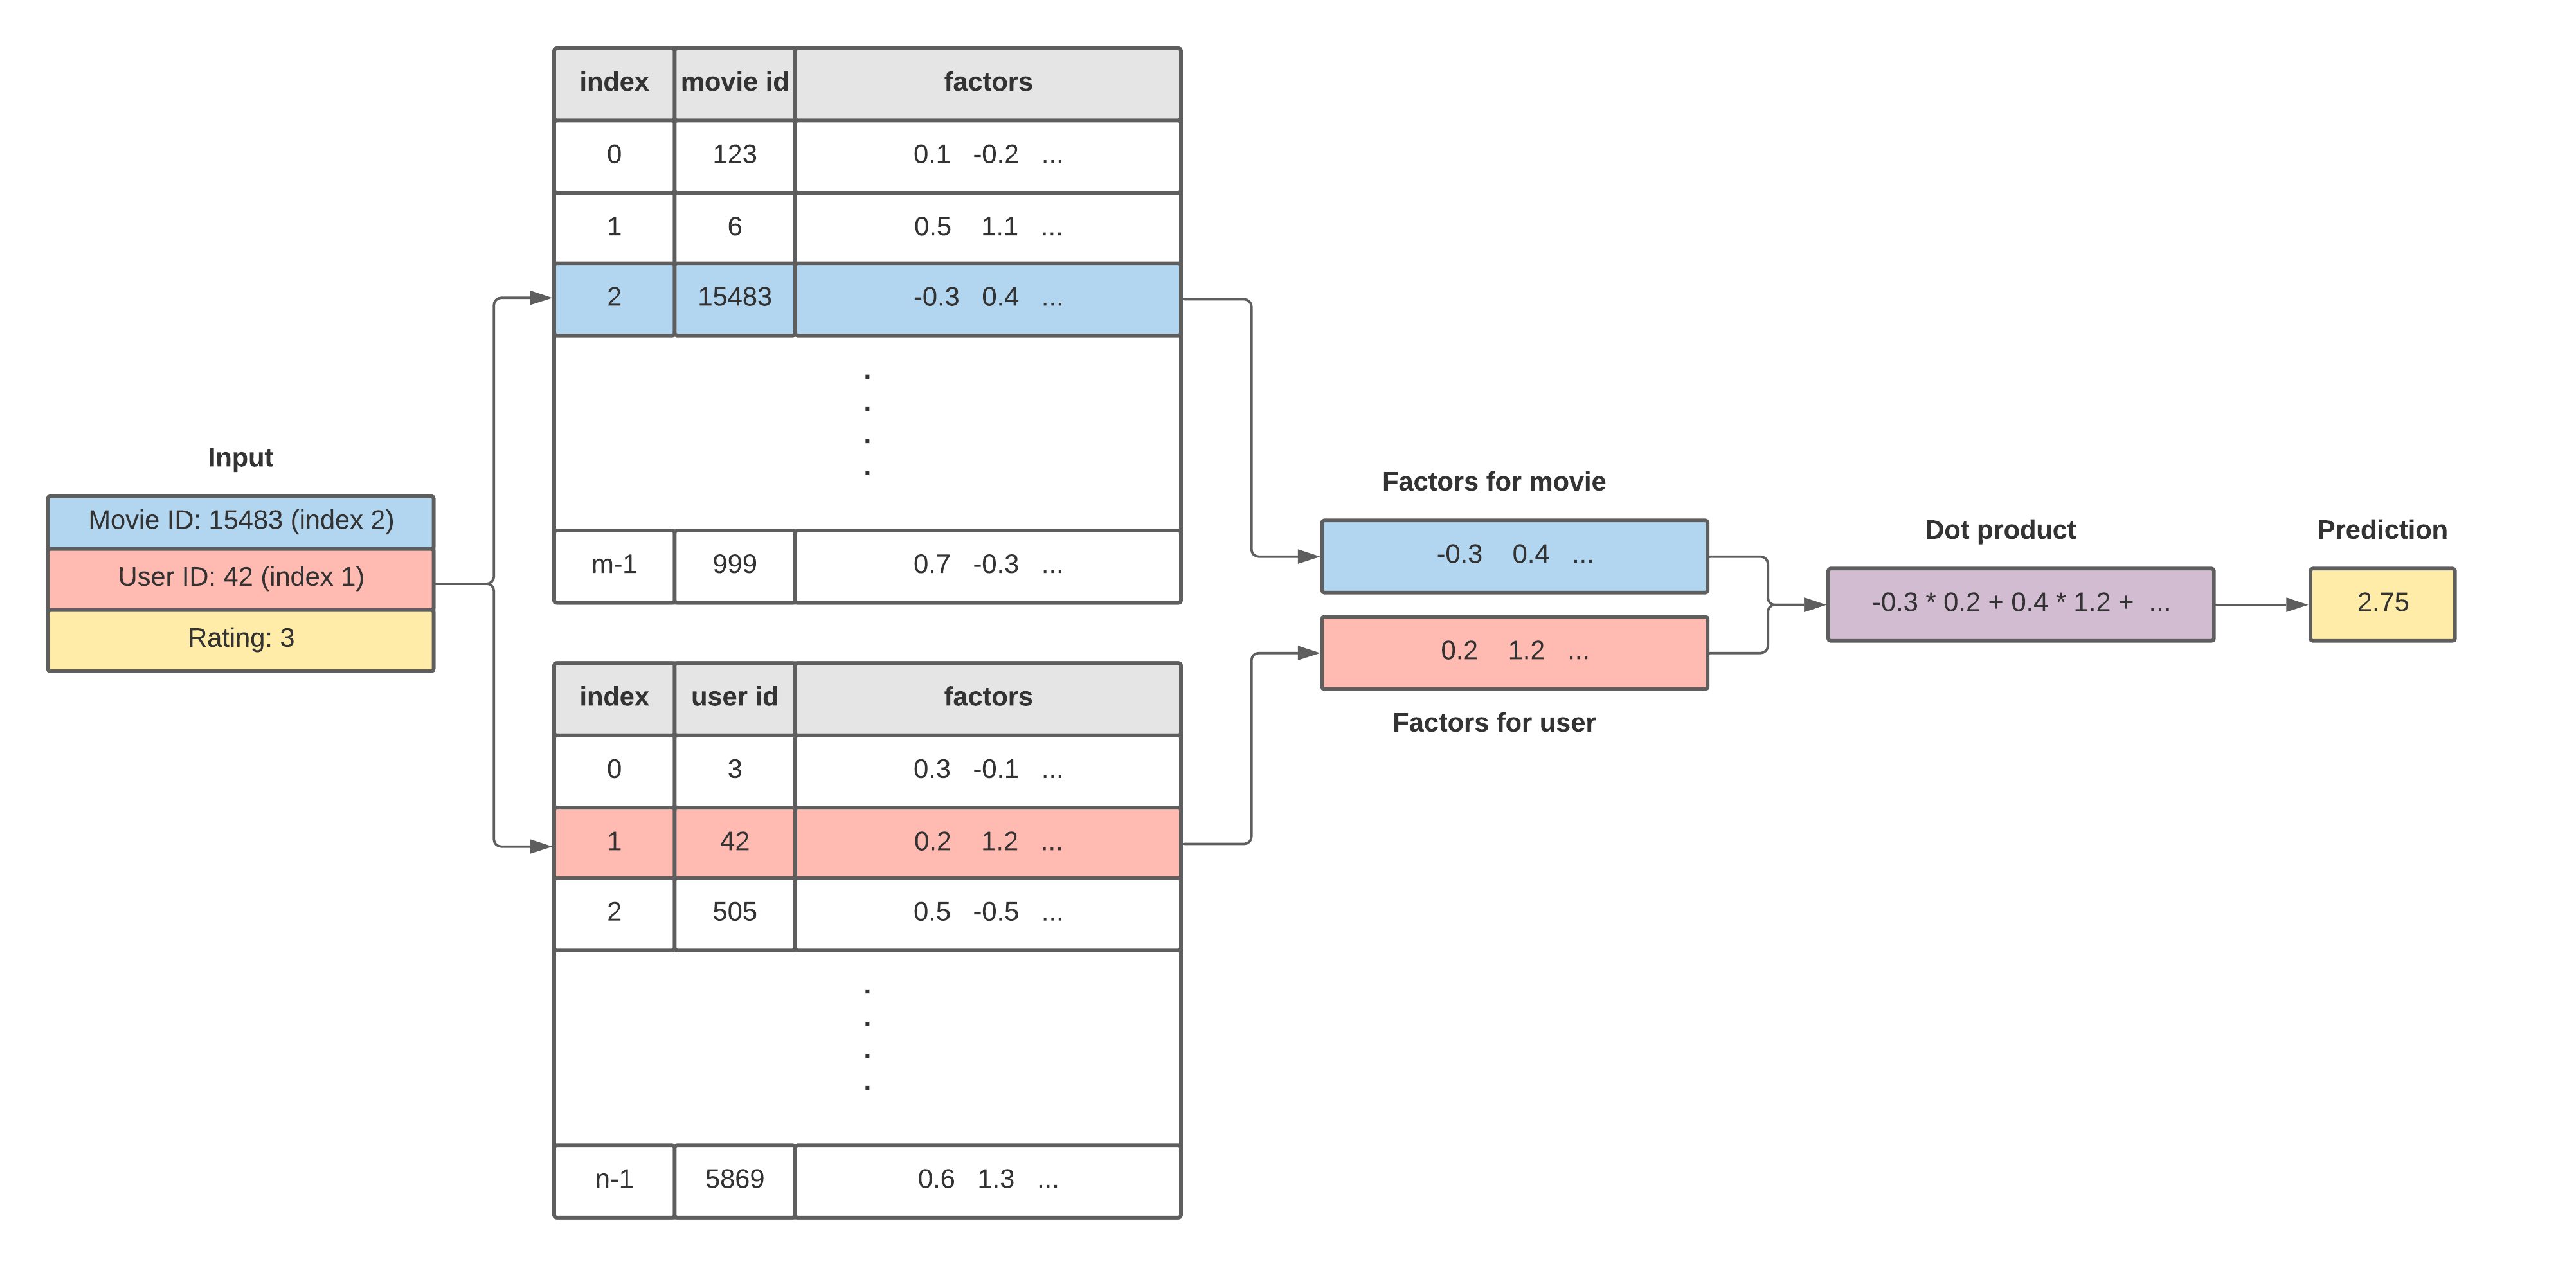

In [ ]:
class MatrixFactorization(models.Model):
    def __init__(self, n_users, n_movies, n_factors, **kwargs):
        super(MatrixFactorization, self).__init__(**kwargs)
        self.n_users = n_users
        self.n_movies = n_movies
        self.n_factors = n_factors
        
        # We specify the size of the matrix,
        # the initializer (truncated normal distribution)
        # and the regularization type and strength (L2 with lambda = 1e-6)
        self.user_emb = layers.Embedding(n_users, 
                                         n_factors, 
                                         embeddings_initializer='he_normal',
                                         embeddings_regularizer=keras.regularizers.l2(1e-6),
                                         name='user_embedding')
        self.movie_emb = layers.Embedding(n_movies, 
                                          n_factors, 
                                          embeddings_initializer='he_normal',
                                          embeddings_regularizer=keras.regularizers.l2(1e-6),
                                          name='movie_embedding')
        
        # Embedding returns a 3D tensor with one dimension = 1, so we reshape it to a 2D tensor
        self.reshape = layers.Reshape((self.n_factors,))
        
        # Dot product of the latent vectors
        self.dot = layers.Dot(axes=1)

    def call(self, inputs):
        # Two inputs
        user, movie = inputs
        u = self.user_emb(user)
        u = self.reshape(u)
    
        m = self.movie_emb(movie)
        m = self.reshape(m)
        
        return self.dot([u, m])

n_factors = 50
model = MatrixFactorization(n_users, n_movies, n_factors)
model.compile(
    optimizer=keras.optimizers.Adam(lr=0.001),
    loss=keras.losses.MeanSquaredError()
)

In [ ]:
try:
    model.summary()
except ValueError as e:
    print(e, type(e))

This is why building models via subclassing is a bit annoying - you can run into errors such as this. We'll fix it by calling the model with some fake data so it knows the shapes of the inputs. 

In [ ]:
_ = model([np.array([1, 2, 3]), np.array([2, 88, 5])])
model.summary()

We're going to expand our toolbox by introducing callbacks. Callbacks can be used to monitor our training progress, decay the learning rate, periodically save the weights or even stop early in case of detected overfitting. In Keras, they are really easy to use: you just create a list of desired callbacks and pass it to the `model.fit` method. It's also really easy to define your own by subclassing the `Callback` class. You can also specify when they will be triggered - the default is at the end of every epoch.

We'll use two: an early stopping callback which will monitor our loss and stop the training early if needed and TensorBoard, a utility for visualizing models, monitoring the training progress and much more. 

In [ ]:
callbacks = [
    keras.callbacks.EarlyStopping(
        # Stop training when `val_loss` is no longer improving
        monitor='val_loss',
        # "no longer improving" being defined as "no better than 1e-2 less"
        min_delta=1e-2,
        # "no longer improving" being further defined as "for at least 2 epochs"
        patience=2,
        verbose=1,
    ),
    keras.callbacks.TensorBoard(log_dir='logs')
]

history = model.fit(
    x=(df['user'].values, df['movie'].values),  # The model has two inputs!
    y=df['rating'],
    batch_size=128,
    epochs=20,
    verbose=1,
    validation_split=0.1,
    callbacks=callbacks
)

We see that we stopped early because the validation loss was not improving. Now, we'll open TensorBoard (it's a separate program called via command-line) to read the written logs and visualize the loss over all epochs. We will also look at how to visualize the model as a computational graph.

In [ ]:
# Run TensorBoard and specify the log dir
%tensorboard --logdir logs

We've seen how easy it is to implement a recommender system with Keras and use a few utilities to make it easier to experiment. Note that this model is still quite basic and we could easily improve it: we could try adding a bias for each user and movie or adding non-linearity by using a sigmoid function and then rescaling the output. It could also be extended to use other features of a user or movie. 

Next, we'll try a bigger, more state-of-the-art model: a deep autoencoder.